# Pulmonary Fibrosis Progression (I)

## Analysis of tabular data

In this notebook we are exploring the input data to get a better understanding on the main properties and the correlelation between them.

Some of the questions we are going to be answering:


In [33]:
## Imports

import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#plotly
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

from sklearn import preprocessing

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

### Overview of the train and test dataset
In this first section we are going to investigate both test and train datasets to get some of the basic information about it.

In [34]:
train_df = pd.read_csv( 'data/train.csv' )
test_df  = pd.read_csv( 'data/test.csv' )
print(f'[train_df] shape: {train_df.shape}')
print(f'[test_df] shape: {test_df.shape}')

[train_df] shape: (1549, 7)
[test_df] shape: (5, 7)


In [35]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [36]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [37]:
print(f'[train_df] Number of rows: {train_df["Patient"].count()}')
print(f'[train_df] Number of unique patients: {train_df["Patient"].unique().shape[0]}')
print(f'[test_df] Number of rows: {test_df["Patient"].count()}')
print(f'[test_df] Number of unique patients: {test_df["Patient"].value_counts().shape[0]}')
print(f'[train_df] SmokingStatus values: {train_df["SmokingStatus"].value_counts().index.tolist()}')
print(f'[test_df] SmokingStatus values: {test_df["SmokingStatus"].value_counts().index.tolist()}')

[train_df] Number of rows: 1549
[train_df] Number of unique patients: 176
[test_df] Number of rows: 5
[test_df] Number of unique patients: 5
[train_df] SmokingStatus values: ['Ex-smoker', 'Never smoked', 'Currently smokes']
[test_df] SmokingStatus values: ['Ex-smoker', 'Never smoked']


In [52]:

'''
BLOCK OF CODE JUST TO RUN IF YOU HAVE THE IMAGES - NOT NEEDED IN GENERAL

train_images_path = "data/train"
test_images_path = "data/test"
num_train_folders = 0
num_test_folders = 0
train_patient_array = np.array(os.listdir(train_images_path))
test_patient_array = np.array(os.listdir(test_images_path))

for root, dirnames, filenames in os.walk(train_images_path):
    num_train_folders += len(dirnames)

for root, dirnames,filenames in os.walk(test_images_path):
    num_test_folders += len(dirnames)

print(f'Number of train CT scan folders: {num_train_folders}')
print(f'Number of test CT scan folders: {num_test_folders}')
print(f'[TRAIN] Does every patient have a CT scan folder? '+
      ('yes :) ' if len(np.setdiff1d(train_df["Patient"].unique(), train_patient_array))==0 else 'No :('))
print(f'[TEST] Does every patient have a CT scan folder? '+
      ('yes :) ' if len(np.setdiff1d(test_df["Patient"].unique(), test_patient_array))==0 else 'No :('))

'''


'\nBLOCK OF CODE JUST TO RUN IF YOU HAVE THE IMAGES - NOT NEEDED IN GENERAL\n\ntrain_images_path = "data/train"\ntest_images_path = "data/test"\nnum_train_folders = 0\nnum_test_folders = 0\ntrain_patient_array = np.array(os.listdir(train_images_path))\ntest_patient_array = np.array(os.listdir(test_images_path))\n\nfor root, dirnames, filenames in os.walk(train_images_path):\n    num_train_folders += len(dirnames)\n\nfor root, dirnames,filenames in os.walk(test_images_path):\n    num_test_folders += len(dirnames)\n\nprint(f\'Number of train CT scan folders: {num_train_folders}\')\nprint(f\'Number of test CT scan folders: {num_test_folders}\')\nprint(f\'[TRAIN] Does every patient have a CT scan folder? \'+\n      (\'yes :) \' if len(np.setdiff1d(train_df["Patient"].unique(), train_patient_array))==0 else \'No :(\'))\nprint(f\'[TEST] Does every patient have a CT scan folder? \'+\n      (\'yes :) \' if len(np.setdiff1d(test_df["Patient"].unique(), test_patient_array))==0 else \'No :(\'))\n

#### [Summary] Overview of tabular data

* Each of the rows in the train and test dataset contains information for a patient visit with details about:
 * Weeks- the relative number of weeks pre/post the baseline CT (may be negative)
 * FVC - the recorded lung capacity in ml
 * Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
 * Age
 * Sex
 * SmokingStatus
* SmokingStatus values
 * Ex-smoker
 * Never smoked
 * Currently smokes
* Train and test dataset contain 176 and 5 unique patients respectively.

#### [Summary] Overview of dicom data
* Every patient in the tabular data has a directory containing the images of the baseline CT scan.

### Analysis of the Tabular data
In this section we are going to look at the nature of the tabular data given as part of the input dataset. The main idea is understand better the distribution of the data per each of the identified features (FVC, percent, age, sex and smoking status). Also we are going to look at how the data changes in time by anaylising patient data between weeks.

In [39]:
# create patient dataframe: patient, baseline_fvc, baseline_percentage, age, sex, smoking status, num_visits
#Creating new rows
patients = []
age = []
sex = []
smoking_status = []
num_visits = []

#for each unique patient filter collect static data
for patient in train_df["Patient"].unique():
    patient_rows = train_df[train_df['Patient'] == patient]
    patient_row = patient_rows.iloc[0]
    patients.append(patient_row['Patient'])
    age.append(patient_row['Age'])
    sex.append(patient_row['Sex'])
    smoking_status.append(patient_row['SmokingStatus'])
    num_visits.append(patient_rows.shape[0])
    
patient_df = pd.DataFrame(list(zip(patients, age, sex, smoking_status, num_visits)), 
                                 columns =['Patient', 'Age', 'Sex', 'Smoking_Status', 'Num_Visits'])
print(patient_df.info())
patient_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Patient         176 non-null    object
 1   Age             176 non-null    int64 
 2   Sex             176 non-null    object
 3   Smoking_Status  176 non-null    object
 4   Num_Visits      176 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.0+ KB
None


,Patient,Age,Sex,Smoking_Status,Num_Visits
0,ID00007637202177411956430,79,Male,Ex-smoker,9
1,ID00009637202177434476278,69,Male,Ex-smoker,9
2,ID00010637202177584971671,60,Male,Ex-smoker,9
3,ID00011637202177653955184,72,Male,Ex-smoker,9
4,ID00012637202177665765362,65,Male,Never smoked,9


In [40]:
def plot_sex_distribution(patient_df):
    '''Plots sex distribution as a pie from patient_df
       :param patient_df: dataframe contianing patient information
       '''
    male_condition = patient_df['Sex'] == 'Male'
    female_condition = patient_df['Sex'] == 'Female'
    sex_distribution = pd.DataFrame({
        'Sex': ['Male', 'Female'], 
        'Count': [patient_df[male_condition]['Patient'].count(), patient_df[female_condition]['Patient'].count()]})
    fig = px.pie(sex_distribution, values='Count', names='Sex', title='Sex distribution')
    fig.show()
    
def plot_patient_df_age_over_sex(patient_df):
    '''Plots patients's age distributions from patient_df
       :param patient_df: dataframe contianing patient information
       '''
    # plot patient age distribution
    male_condition = patient_df['Sex'] == 'Male'
    female_condition = patient_df['Sex'] == 'Female'
    age_distribution_over_sex = pd.concat([patient_df[male_condition]['Age'].value_counts(),
                                           patient_df[female_condition]['Age'].value_counts()],
                                          axis=1, ignore_index=True).fillna(0)
    age_distribution_over_sex = age_distribution_over_sex.rename(columns={0: "Male", 1: "Female"})
    age_distribution_over_sex.iplot(kind='bar',
                                      xTitle='Age',
                                      yTitle='Counts',
                                      linecolor='black', 
                                      opacity=0.7,
                                      theme='pearl',
                                      bargap=0.3,
                                      barmode='stack',
                                      gridcolor='white',
                                      title='Age distribution over Sex')
    
def plot_patient_df_smoking_status_over_sex(patient_df):
    '''Plots patients's smoking status distributions 
       :param patient_df: dataframe contianing patient information
    '''
    # plot patient age distribution
    smoking_status_male = []
    smoking_status_female = []
    for smoking_status in patient_df['Smoking_Status'].unique():
        male_condition = (patient_df['Smoking_Status'] == smoking_status) & (patient_df['Sex'] == 'Male')
        female_condition = (patient_df['Smoking_Status'] == smoking_status) & (patient_df['Sex'] == 'Female')
        smoking_status_male.append(patient_df[male_condition]['Patient'].count())
        smoking_status_female.append(patient_df[female_condition]['Patient'].count())
    smoking_status_over_sex_distribution = pd.DataFrame({
        'Male': smoking_status_male, 
        'Female': smoking_status_female}, index=[patient_df['Smoking_Status'].unique()])
    smoking_status_over_sex_distribution.iplot(kind='bar',
                                      xTitle='Smoking Distribution',
                                      yTitle='Count (over Sex)',
                                      linecolor='black', 
                                      opacity=0.7,
                                      theme='pearl',
                                      bargap=0.3,
                                      barmode='stack',
                                      gridcolor='white',
                                      title='Smoking distribution over Sex')

plot_sex_distribution(patient_df) 
plot_patient_df_age_over_sex(patient_df)
plot_patient_df_smoking_status_over_sex(patient_df)

#### [Conclusions] Sex, Age and Smoking Status Distribution conclusions
* Almost 80% of patients in our train dataset are males
* The majority of the patients are aged between 60 and 75 
* The majority of the patients are ex-smokers and males

In [41]:
def plot_capacity_type_per_age(data_df, capacity_type='FVC'):
    '''Plots the capacity type per age
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    fig = px.scatter(train_df, x=capacity_type, y="Age", color='Age', title=f'Distribution of {capacity_type} per age')
    fig.show()

def plot_capacity_type_per_sex(data_df, capacity_type='FVC'):
    '''Plots the fvc per sex
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    hist_data = [data_df.groupby('Sex').get_group('Male')[capacity_type],
                 data_df.groupby('Sex').get_group('Female')[capacity_type]]
    
    group_labels = ['Male', 'Female']
    colors = ['orange', 'blue']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors,bin_size=bins_per_capacity_type(capacity_type),
                             show_curve=True)

    fig.update(layout_title_text=f'Distribution of {capacity_type} per Sex')
    fig.show()
    
def plot_capacity_type_per_smoking_status(data_df, capacity_type='FVC'):
    '''Plots the capacity type per smoking status
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    hist_data = [data_df.groupby('SmokingStatus').get_group('Ex-smoker')[capacity_type],
                 data_df.groupby('SmokingStatus').get_group('Never smoked')[capacity_type],
                 data_df.groupby('SmokingStatus').get_group('Currently smokes')[capacity_type]]

    group_labels = ['Ex-Smokers', 'Never Smoked', 'Current Smokers']
    colors = ['purple', 'green', 'orange']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors,bin_size=bins_per_capacity_type(capacity_type), show_curve=True)

    fig.update(layout_title_text=f'Distribution of {capacity_type} per Smoking Status')
    fig.show()

def plot_capacity_type_per_weeks_over_smoking_status(data_df, capacity_type='FVC'):
    '''Plots the capacity type over weeks
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
    '''
    fig = px.scatter(data_df, x="Weeks", y=capacity_type, color="SmokingStatus", hover_name="SmokingStatus",
                    title=f'Evolution of {capacity_type} per week by Smoking Status')
    fig.show()

def bins_per_capacity_type(capacity_type):
    return 15 if capacity_type == 'FVC' else 5

plot_capacity_type_per_age(train_df, 'FVC')
plot_capacity_type_per_sex(train_df, 'FVC')

In [42]:
plot_capacity_type_per_smoking_status(train_df, 'FVC')
plot_capacity_type_per_weeks_over_smoking_status(train_df, 'FVC')

#### [Conclusions] Distribution of FVC per Age, Sex and Smoking Status
* In general older people tend to have less lung capacity (FVC)
* Average lung capacity is substantially lower for females than for males
* It is not clear that ex-smokers or current smokers have less lung capacity. We need to look at segmenting this data by Sex too, as this might be also influenced by the fact that almost all the ex-smokers are males and those usually have more capacity as mentioned above. (TODO)

In [43]:
plot_capacity_type_per_age(train_df, 'Percent')
plot_capacity_type_per_sex(train_df, 'Percent')

In [44]:
plot_capacity_type_per_smoking_status(train_df, 'Percent')
plot_capacity_type_per_weeks_over_smoking_status(train_df, 'Percent')

#### [Conclusions] Distribution of Percent per Age, Sex and Smoking Status
* It is interesting to see that in general younger patients have lower percent, which means that have less capacity than a person of similar characteristics.
* Percent per sex looks more balanced than FVC per sex, which might indicate that there is no evidence that a particular sex is more prone than the other to have a more rapid deterioration.
* Again there is no evidence than a smoker person has less capacity than a person of the same characteristics, but we need to analyse this data by sex.

In [45]:
def plot_capacity_type_per_smoking_status_and_sex(data_df, capacity_type='FVC', sex='Male'):
    '''Plots the capacity type per smoking status
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    sex_condition = data_df['Sex'] == sex
    hist_data = [data_df[sex_condition].groupby('SmokingStatus').get_group('Ex-smoker')[capacity_type],
                 data_df[sex_condition].groupby('SmokingStatus').get_group('Never smoked')[capacity_type],
                 data_df[sex_condition].groupby('SmokingStatus').get_group('Currently smokes')[capacity_type]]

    group_labels = ['Ex-Smokers', 'Never Smoked', 'Current Smokers']
    colors = ['purple', 'green', 'orange']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors,bin_size=bins_per_capacity_type(capacity_type), show_curve=True)

    fig.update(layout_title_text=f'Distribution of {capacity_type} per Smoking Status and {sex}')
    fig.show()

In [46]:
plot_capacity_type_per_smoking_status_and_sex(train_df, 'Percent', 'Male')
plot_capacity_type_per_smoking_status_and_sex(train_df, 'Percent', 'Female')

#### [Conclusions] Percent over Smoking Status and Sex
* We can confirm that there is no evidence that being a smoker or ex-smoker implies to have less lung capacity. However we still need to understand if it could imply a more rapid deterioration. 

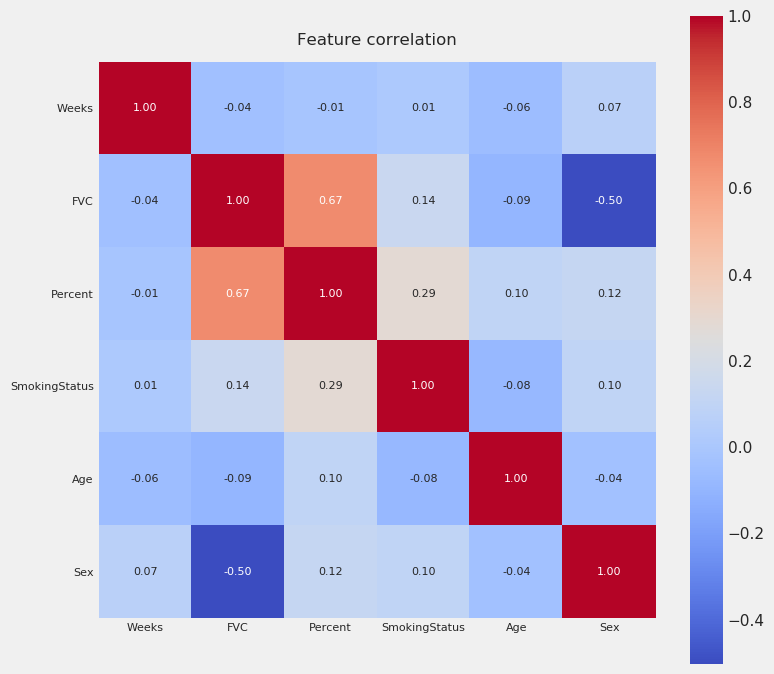

In [54]:
def plot_correlation_matrix(data_df, features=['Weeks', 'FVC', 'Percent', 'Age']):
    fig = plt.figure(figsize=(8, 8), dpi=100)
    correlation_df = data_df.copy()
    if 'SmokingStatus' in correlation_df.columns:
        correlation_df['SmokingStatus'] = correlation_df['SmokingStatus'].map({'Ex-smoker':0, 'Currently smokes': 1, 'Sever smoked': 2})
    if 'Sex' in correlation_df.columns:
        correlation_df['Sex'] = correlation_df['Sex'].map({'Male':0, 'Female': 1})
    sns.heatmap(correlation_df[features].corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 8},  fmt='.2f')   

    plt.tick_params(axis='x', labelsize=8, rotation=0)
    plt.tick_params(axis='y', labelsize=8, rotation=0)
    plt.title('Feature correlation', size=12, pad=12)

    plt.show()
    
features = ['Weeks', 'FVC', 'Percent', 'SmokingStatus', 'Age', 'Sex']
plot_correlation_matrix(train_df, features)

#### [Conclusions] Correlation Tabular Data
* There is really low correlation between our features apart from FVC and Percentage.
* The correlation between percentage and FVC is expected as both are measuring lung capacity. We might want to omit one of those when training our model as information is redundant until certain extend.
* There is a bit of correlation between SmokingStatus which might indicate that a relationship between both features exists over time.

In [48]:
def plot_weeks_distribution(data_df):
    '''Plots the number of patient's visits per week in the dataset.
       :param data_df: data dataframe which should correspond with the format of the train and test dataset
    '''
    # plot weeks distribution
    train_df['Weeks'].value_counts().iplot(kind='bar',
                              xTitle='Week',
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='blue',
                              theme='pearl',
                              bargap=0.3,
                              gridcolor='white',
                              title='Weeks distribution')
plot_weeks_distribution(train_df)

### Creation of Train and Test CSVs

In the next part we are going to focus into creating the train dataset from our tabular data. We are going to create a single `train.csv` without headers with the following format:

* FVC 
* age
* base_FVC -> fvc of the first measurement 
* week -> num of weeks from first measurement
* percent
* sex
* smoking_status

In order to do that we need to calculate per raw in the train_df: base_fvc and week.

Later we need to normalise the values, and then we can create our `train.csv`

In [49]:
if not os.path.exists('data/pp'): 
    os.mkdir('data/pp')
train_df.to_csv(path_or_buf='data/pp/train_df.csv', header=True, index=False)
test_df.to_csv(path_or_buf='data/pp/test_df.csv', header=True, index=False)
submission_df = pd.read_csv(filepath_or_buffer=os.path.join("data/", "sample_submission.csv"),
                                header=0, names=None)

In [50]:
# save as csv without columns 
def make_csv(pp_train_df, pp_test_df, results_df, bucket_name='fibrosis-poc/data/'):
    '''method that creates a csv for train and test datasets. 
       :param pp_train_df: train dataset
       :param pp_test_df: test dataset
       :param bucket_name: Name of the bucket in which to store both csvs
       '''
    pp_train_df.to_csv(path_or_buf='data/pp/pp_train.csv', header=False, index=False)
    pp_test_df.to_csv(path_or_buf='data/pp/pp_test.csv', header=False, index=False)
    results_df.to_csv(path_or_buf='data/pp/results.csv', header=True, index=False)
    

Here we are using our pre_processing funtion in `source/preprocess` module which generates the train and test datasets in the way that our neural network needs the information.

In [51]:
from source.preprocess import preprocess_data
pp_train_df, pp_test_df, results_df = preprocess_data(train_df, test_df, submission_df)
make_csv(pp_train_df, pp_test_df, results_df)

# values now are normalised. Note that the first column FVC is our labels for the training exercise.
pp_train_df.head(15)

,FVC,Percent,Age,min_FVC,weeks_from_min,Male,Female,Ex-smoker,Never smoked,Currently smokes,Weeks
0,2315,0.236393,0.769231,0.241456,0.179012,1.0,0.0,1.0,0.0,0.0,0.055172
1,2214,0.215941,0.769231,0.241456,0.234568,1.0,0.0,1.0,0.0,0.0,0.117241
2,2061,0.184960,0.769231,0.241456,0.246914,1.0,0.0,1.0,0.0,0.0,0.131034
3,2144,0.201767,0.769231,0.241456,0.259259,1.0,0.0,1.0,0.0,0.0,0.144828
4,2069,0.186580,0.769231,0.241456,0.271605,1.0,0.0,1.0,0.0,0.0,0.158621
5,2101,0.193059,0.769231,0.241456,0.308642,1.0,0.0,1.0,0.0,0.0,0.200000
6,2000,0.172607,0.769231,0.241456,0.382716,1.0,0.0,1.0,0.0,0.0,0.282759
7,2064,0.185567,0.769231,0.241456,0.456790,1.0,0.0,1.0,0.0,0.0,0.365517
8,2057,0.184150,0.769231,0.241456,0.555556,1.0,0.0,1.0,0.0,0.0,0.475862
9,3660,0.453901,0.512821,0.491270,0.179012,1.0,0.0,1.0,0.0,0.0,0.137931


### [Summary] Creation of Train and Test CSVs
At this moment we have 2 different CSVs: pp_train.csv and pp_test.csv with the data ready for training and test exercise.

Also we have created results.csv which contains a patient and week per each of the rows in the test dataframe. This will be used in the prediction phase to fill the values for the predicted FVC and the confidence of those predictions

*Confidence interval*: predicts the distribution of estimates of the true population mean or other quantity of interest that cannot be observed.